In [15]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [16]:
# !pip install "tensorflow==2.8.0"
# Chạy khi bị lỗi dòng dự báo

# Dataset: VHM Historical Data

In [17]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,68421.0
2019-03-04,70075.0
2019-03-05,68421.0
2019-03-06,69022.0
2019-03-07,69173.0
...,...
2024-05-27,39800.0
2024-05-28,39950.0
2024-05-29,39450.0


In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

## Ratio 7:3

In [19]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [20]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [21]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [23]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 6ms/step - loss: 0.0160
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 9/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 11/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 12/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 13/100
13/13 [=================

In [25]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 4ms/step


In [26]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [27]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1850.811978468866
Testing MAPE: 2.9641932637437347
Testing MAE: 1395.0254906143346


In [28]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

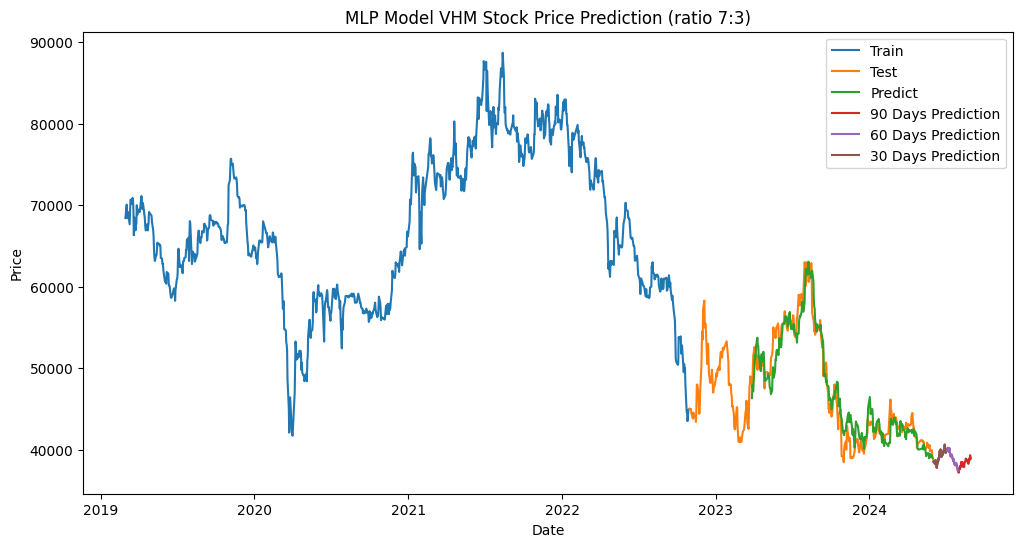

In [29]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 8:2

In [30]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [31]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [32]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [33]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [34]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0442
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 12/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 13/100
15/15 [=================

In [36]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 3ms/step


In [37]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [38]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2894.9728953591552
Testing MAPE: 4.8201878589746405
Testing MAE: 1984.2352430555557


In [39]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

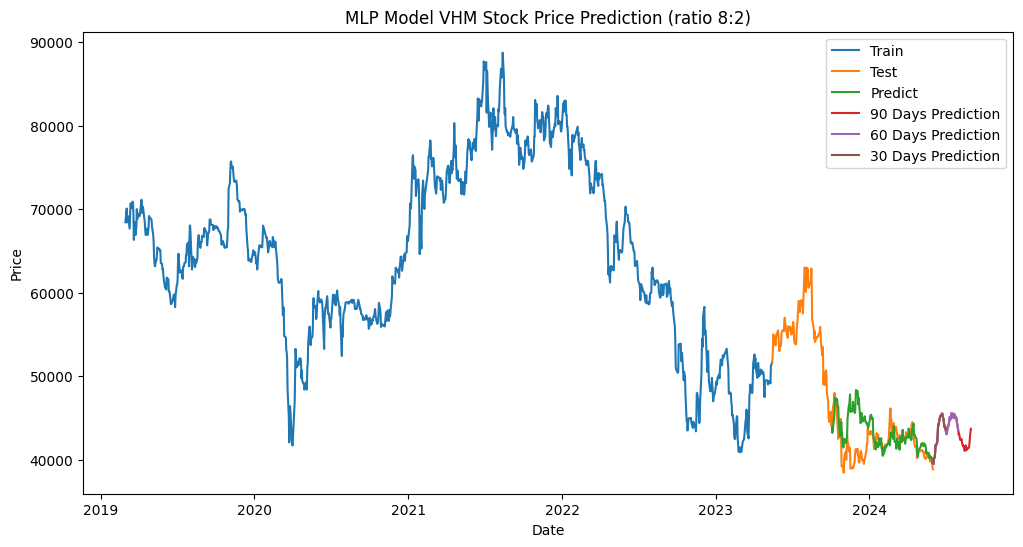

In [40]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 9:1

In [41]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [42]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [43]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [44]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 3ms/step - loss: 0.2201
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 10/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 11/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 12/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 13/100
17/17 [=================

In [47]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 111ms/step


In [48]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [49]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 886.7444257574089
Testing MAPE: 1.6244192851211134
Testing MAE: 663.3670572916667


In [50]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

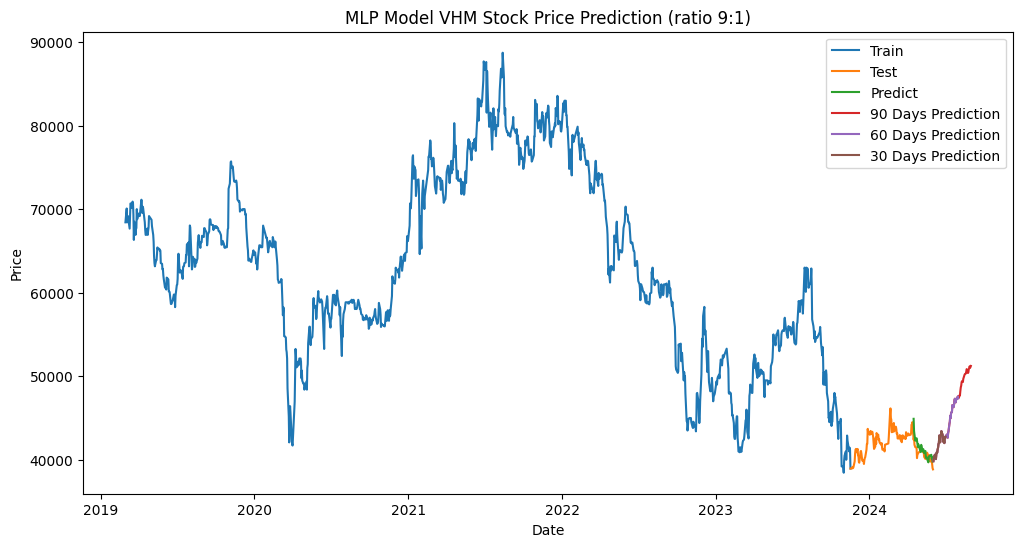

In [51]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

# Dataset: NVL Historical Data

In [123]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,32933.0
2019-03-04,33100.0
2019-03-05,32711.0
2019-03-06,31709.0
2019-03-07,31932.0
...,...
2024-05-27,14500.0
2024-05-28,14500.0
2024-05-29,14150.0


In [124]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

## Ratio 7:3

In [125]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [126]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [127]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [128]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [129]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [130]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 2ms/step - loss: 0.0294
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 11/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 12/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 13/100
13/13 [=================

In [131]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [132]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [133]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1818.2355387095977
Testing MAPE: 7.569997492740084
Testing MAE: 1141.6040522344283


In [134]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

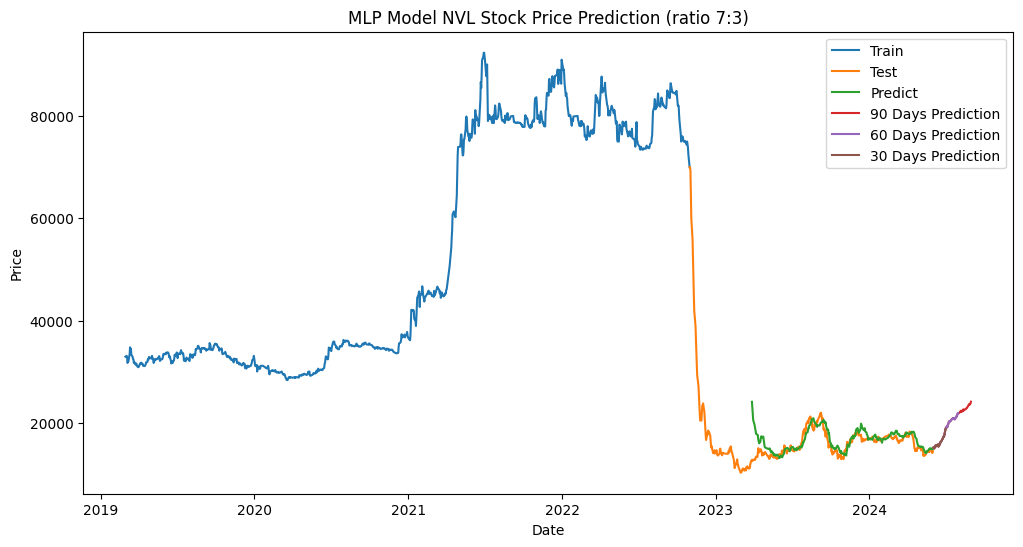

In [135]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 8:2

In [136]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [137]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [138]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [139]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [140]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [141]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0494
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 12/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 13/100
15/15 [=================

In [142]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 3ms/step


In [143]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [144]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1005.0868983050872
Testing MAPE: 4.633143372246373
Testing MAE: 754.7681447723766


In [145]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

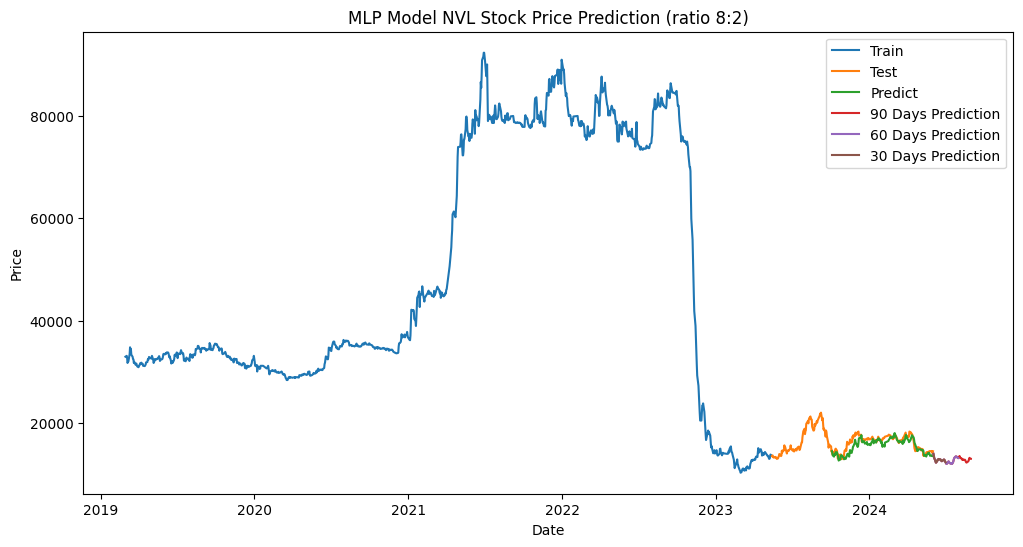

In [146]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 9:1

In [147]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [148]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [149]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [150]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [151]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [152]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 2ms/step - loss: 0.0401
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 11/100
17/17 [==============================] - 0s 3ms/step - loss: 9.9737e-04
Epoch 12/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 13/100
17/17 [=============

In [153]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 86ms/step


In [154]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [155]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 452.32861356965674
Testing MAPE: 2.3002299814710883
Testing MAE: 338.32985026041655


In [156]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

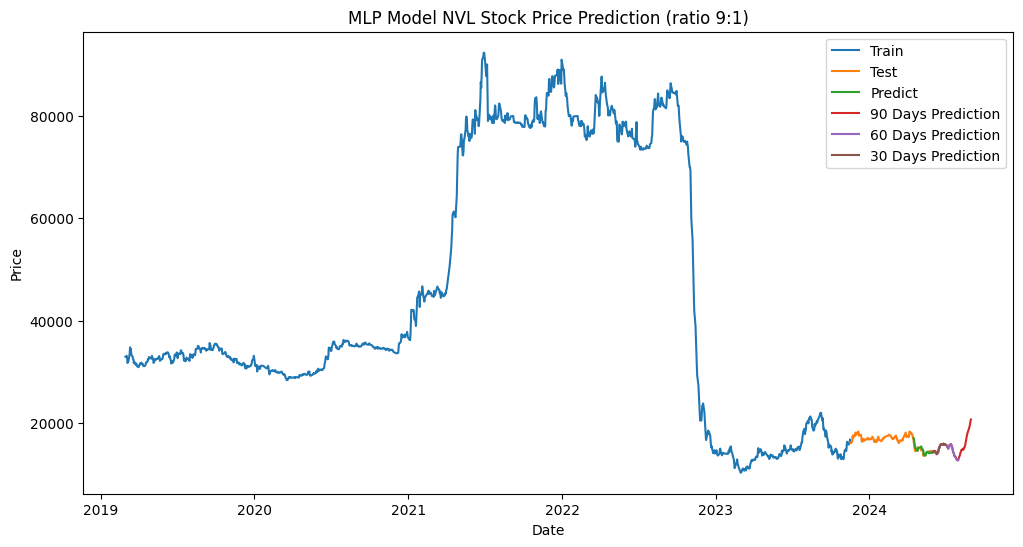

In [157]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

# Dataset: NLG Historical Data

In [88]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,18706.8
2019-03-04,19127.2
2019-03-05,18917.0
2019-03-06,18846.9
2019-03-07,18706.8
...,...
2024-05-27,43900.0
2024-05-28,43701.0
2024-05-29,44400.0


In [89]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

## Ratio 7:3

In [90]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [91]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [92]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [93]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [94]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [95]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 3ms/step - loss: 0.0297
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 11/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 12/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 13/100
13/13 [=================

In [96]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [97]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [98]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1575.9786592198304
Testing MAPE: 3.5153105048269637
Testing MAE: 1262.3234854948805


In [99]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

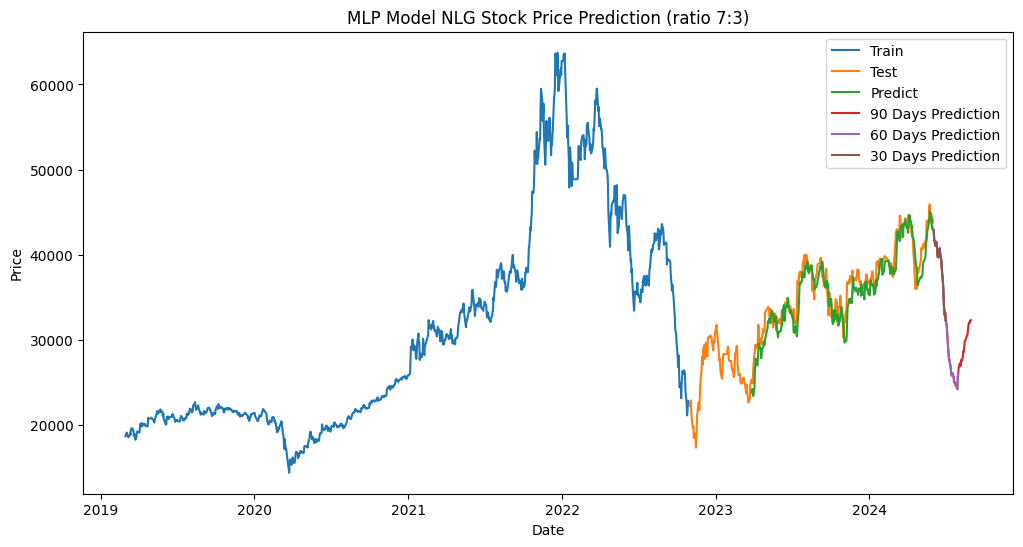

In [100]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 8:2

In [101]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [102]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [103]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [104]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [105]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [106]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0154
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 12/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 13/100
15/15 [=================

In [107]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [108]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [109]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1654.4406908170465
Testing MAPE: 3.4642550142523856
Testing MAE: 1325.0272472993827


In [110]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

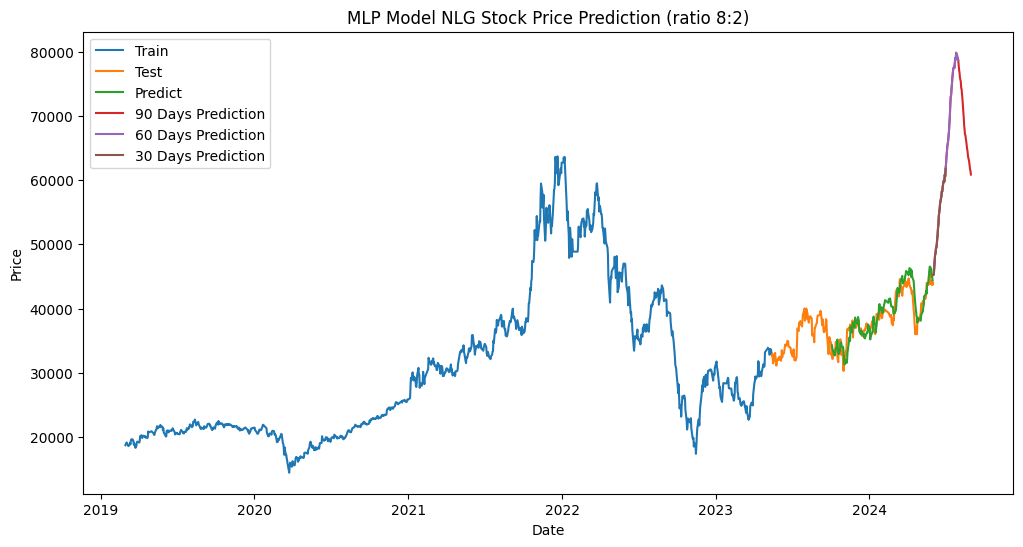

In [111]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 9:1

In [112]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [113]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [114]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [115]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [116]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=time_step, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [117]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 3ms/step - loss: 0.0289
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 11/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 12/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 13/100
17/17 [=================

In [118]:
# 9. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 72ms/step


In [119]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [120]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2081.4111422113237
Testing MAPE: 3.8143848011465344
Testing MAE: 1521.1483072916667


In [121]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

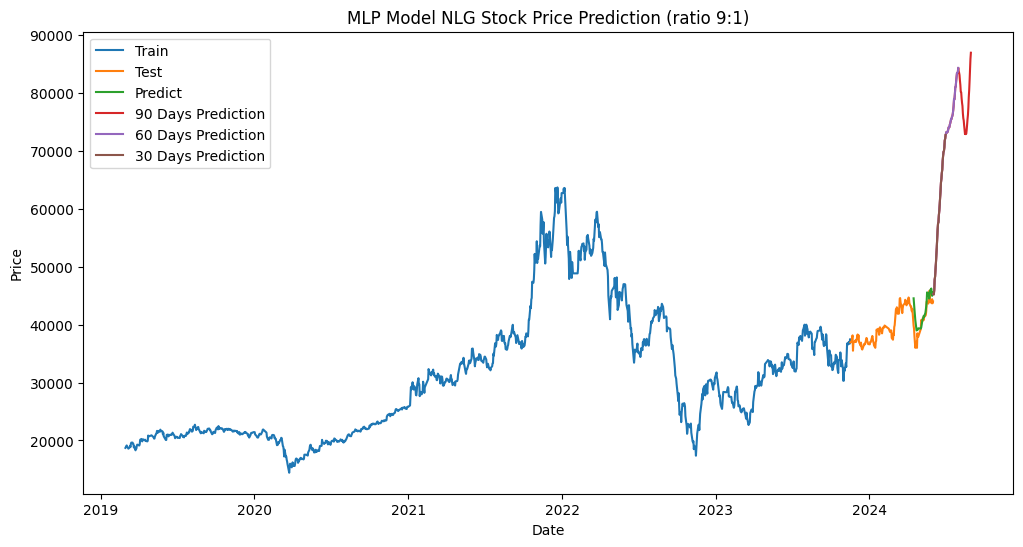

In [122]:
# 13. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('MLP Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()